In [1]:
import os
import pandas as pd

In [2]:
data_dir = "data"
data_folder = "aclImdb"
data_url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filename = "aclImdb_v1.tar.gz"
sample_idx = 42
cache_dir = os.path.join("cache", "sentiment_analysis")
pytorch_dir = 'data/pytorch' # The folder we will use for storing data

### Step 1: Downloading the data

In [3]:
import tarfile
from urllib.request import urlretrieve
from pathlib import Path

def download_data(data_dir, data_url, filename):
    Path(data_dir).mkdir(parents=True, exist_ok=True)
    download = urlretrieve(url=data_url, filename=Path(data_dir).joinpath(filename))
    tar = tarfile.open(name=download[0], mode='r|*')
    tar.extractall(data_dir)
    tar.close()

In [4]:
download_data(data_dir, data_url, filename)

In [5]:
import os
import glob
from pathlib import Path

def read_imdb_data(data_dir, data_folder):
    imdb_dir = Path(data_dir).joinpath(data_folder)
    data = {}
    labels = {}
    
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}
        
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            path = os.path.join(imdb_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    # Here we represent a positive review by '1' and a negative review by '0'
                    labels[data_type][sentiment].append(1 if sentiment == 'pos' else 0)
                    
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
                
    return data, labels

In [6]:
data, labels = read_imdb_data(data_dir, data_folder)

In [7]:
print("IMDB reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
            len(data['train']['pos']), len(data['train']['neg']),
            len(data['test']['pos']), len(data['test']['neg'])))

IMDB reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


In [8]:
from sklearn.utils import shuffle

def prepare_imdb_data(data, labels):
    """Prepare training and test sets from IMDb movie reviews."""
    
    #Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    #Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

In [9]:
train_valid_X, test_X, train_valid_y, test_y = prepare_imdb_data(data, labels)

In [10]:
from sklearn.model_selection import train_test_split

def split_train_validation_data(train_valid_X, train_valid_y, valid_size=0.3, random_state=42):
    train_X, valid_X, train_y, valid_y = train_test_split(train_valid_X,
                                                          train_valid_y, 
                                                          test_size=valid_size, 
                                                          random_state=random_state)
    return train_X, valid_X, train_y, valid_y

In [11]:
train_X, valid_X, train_y, valid_y = split_train_validation_data(train_valid_X, train_valid_y, valid_size=0.3)

In [12]:
print("IMDb reviews (combined): train = {}, valid = {}, test = {}".format(len(train_X), len(valid_X),len(test_X)))

IMDb reviews (combined): train = 17500, valid = 7500, test = 25000


In [13]:
print(f"sentiment: {train_y[sample_idx]}")
print(f"review: {train_X[sample_idx]}")

sentiment: 0
review: I wasn't as "lucky" as some of the others commenting on this film: i have never seen anything else out of the...shall we say... "fecund" mind of Sarno. I agree with many: some of the actresses who spend a lot of time topless and (go-go) dancing are not really that attractive. I kinda liked Fraulein Crank(?)...she was so homely , she was cute! The acting was pretty stale, also, though delivering lines in a second language might have accounted for a lot of that problem. Trying to follow the plot was a major chore: was there one, really? I do heartily agree with one other comment: for a vampire movie, there's not much blood. Yep, if you want GOOD bloodsucking flicks, check out such Hammer classics as "Horror of Dracula" and (my personal favourite) "Brides of Dracula".<br /><br />The most (unintentionally) humorous part is where the lady doctor gets her clothes torn off by a cloud of bats...which you never SEE!...the bats, I mean.<br /><br />Okay as a time-waster if yo

In [14]:
print(f"sentiment: {valid_y[sample_idx]}")
print(f"review: {valid_X[sample_idx]}")

sentiment: 1
review: I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where Shawn named his big monster of a body guard Diesel, IRS vs 1-2-3 Kid, Bret Hart first takes on Doink then takes on Jerry Lawler and stuff with the Harts and Lawler was always very interesting, then Ludvig Borga destroyed Marty Jannetty, Undertaker took on Giant Gonzalez in another terrible match, The Smoking Gunns and Tatanka took on Bam Bam Bigelow and the Headshrinkers, and 

In [15]:
print(f"sentiment: {test_y[sample_idx]}")
print(f"review: {test_X[sample_idx]}")

sentiment: 0
review: To call a film boring is not something I would usually count as a valid criticism. However, when a film is crassly made of spare parts from other films that weren't that good to begin with, and it is slow as molasses with no real payoff, I think it's fair to call a spade a spade. And The Ghost is a very boring film.<br /><br />A movie that is about as original as its' name, The Ghost tells the story of a young girl with amnesia being haunted by a ghost that holds the secret to her past. Only, it's a whole lot more complicated and less interesting than one would think.<br /><br />The plot line is almost incomprehensible for most of the picture and the hook, the amnesia element, only makes things worse. It seems that no one, including the screenwriter and director have any clue what the hell is happening at any given moment. Instead they chose to do what roughly amounts to the filmic equivalent of a sitcom clip show. There are scenes taken directly from Ringu, Dark W

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import re
from bs4 import BeautifulSoup

def review_to_words(review):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

In [17]:
print(review_to_words(train_X[sample_idx]))

['lucki', 'other', 'comment', 'film', 'never', 'seen', 'anyth', 'els', 'shall', 'say', 'fecund', 'mind', 'sarno', 'agre', 'mani', 'actress', 'spend', 'lot', 'time', 'topless', 'go', 'go', 'danc', 'realli', 'attract', 'kinda', 'like', 'fraulein', 'crank', 'home', 'cute', 'act', 'pretti', 'stale', 'also', 'though', 'deliv', 'line', 'second', 'languag', 'might', 'account', 'lot', 'problem', 'tri', 'follow', 'plot', 'major', 'chore', 'one', 'realli', 'heartili', 'agre', 'one', 'comment', 'vampir', 'movi', 'much', 'blood', 'yep', 'want', 'good', 'bloodsuck', 'flick', 'check', 'hammer', 'classic', 'horror', 'dracula', 'person', 'favourit', 'bride', 'dracula', 'unintent', 'humor', 'part', 'ladi', 'doctor', 'get', 'cloth', 'torn', 'cloud', 'bat', 'never', 'see', 'bat', 'mean', 'okay', 'time', 'waster', 'happen', 'catch', 'cabl', 'great', 'white', 'north', 'heaven', 'sake', 'rent']


In [18]:
print(review_to_words(valid_X[sample_idx]))

['realli', 'like', 'summerslam', 'due', 'look', 'arena', 'curtain', 'look', 'overal', 'interest', 'reason', 'anyway', 'could', 'one', 'best', 'summerslam', 'ever', 'wwf', 'lex', 'luger', 'main', 'event', 'yokozuna', 'time', 'ok', 'huge', 'fat', 'man', 'vs', 'strong', 'man', 'glad', 'time', 'chang', 'terribl', 'main', 'event', 'like', 'everi', 'match', 'luger', 'terribl', 'match', 'card', 'razor', 'ramon', 'vs', 'ted', 'dibias', 'steiner', 'brother', 'vs', 'heavenli', 'bodi', 'shawn', 'michael', 'vs', 'curt', 'hene', 'event', 'shawn', 'name', 'big', 'monster', 'bodi', 'guard', 'diesel', 'ir', 'vs', '1', '2', '3', 'kid', 'bret', 'hart', 'first', 'take', 'doink', 'take', 'jerri', 'lawler', 'stuff', 'hart', 'lawler', 'alway', 'interest', 'ludvig', 'borga', 'destroy', 'marti', 'jannetti', 'undertak', 'took', 'giant', 'gonzalez', 'anoth', 'terribl', 'match', 'smoke', 'gunn', 'tatanka', 'took', 'bam', 'bam', 'bigelow', 'headshrink', 'yokozuna', 'defend', 'world', 'titl', 'lex', 'luger', 'matc

In [19]:
print(review_to_words(test_X[sample_idx]))

['call', 'film', 'bore', 'someth', 'would', 'usual', 'count', 'valid', 'critic', 'howev', 'film', 'crassli', 'made', 'spare', 'part', 'film', 'good', 'begin', 'slow', 'molass', 'real', 'payoff', 'think', 'fair', 'call', 'spade', 'spade', 'ghost', 'bore', 'film', 'movi', 'origin', 'name', 'ghost', 'tell', 'stori', 'young', 'girl', 'amnesia', 'haunt', 'ghost', 'hold', 'secret', 'past', 'whole', 'lot', 'complic', 'less', 'interest', 'one', 'would', 'think', 'plot', 'line', 'almost', 'incomprehens', 'pictur', 'hook', 'amnesia', 'element', 'make', 'thing', 'wors', 'seem', 'one', 'includ', 'screenwrit', 'director', 'clue', 'hell', 'happen', 'given', 'moment', 'instead', 'chose', 'roughli', 'amount', 'filmic', 'equival', 'sitcom', 'clip', 'show', 'scene', 'taken', 'directli', 'ringu', 'dark', 'water', 'shutter', 'grudg', 'seri', 'smatter', 'puls', 'good', 'measur', 'make', 'matter', 'wors', 'half', 'dozen', 'femal', 'lead', 'dress', 'read', 'line', 'alik', 'make', 'imposs', 'tell', 'apart', '

In [20]:
import pickle
from tqdm import tqdm


os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists
def preprocess_data(data_train, data_test, data_valid, 
                    labels_train, labels_test, labels_valid,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [review_to_words(review) for review in tqdm(data_train)]
        words_valid = [review_to_words(review) for review in tqdm(data_valid)]
        words_test = [review_to_words(review) for review in tqdm(data_test)]
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,words_valid=words_valid,
                              labels_train=labels_train, labels_test=labels_test, labels_valid=labels_valid)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, words_valid, labels_train, labels_test, labels_valid = (cache_data['words_train'],
                cache_data['words_test'], cache_data['words_valid'], 
                cache_data['labels_train'], cache_data['labels_test'], cache_data['labels_valid'])
    return words_train, words_test, words_valid, labels_train, labels_test, labels_valid

In [21]:
train_pp_X, test_pp_X, valid_pp_X, train_pp_y, test_pp_y, valid_pp_y = preprocess_data(train_X, test_X, valid_X,
                                                                           train_y, test_y, valid_y)

100%|██████████| 25000/25000 [09:06<00:00, 45.74it/s]


Wrote preprocessed data to cache file: preprocessed_data.pkl


In [22]:
import numpy as np

def build_dict(data, vocab_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    # TODO: Determine how often each word appears in `data`. Note that `data` is a list of sentences and that a
    #       sentence is a list of words.

    flatten_data = [word for review in data for word in review]
    (unique, counts) = np.unique(flatten_data, return_counts=True)   

    # word_count = {}
    # A dict storing the words that appear in the reviews along with how often they occur
    word_count = zip_word_count = {x:y for x,y in zip(unique, counts)}
    
    # TODO: Sort the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    #       sorted_words[-1] is the least frequently appearing word.
    #sorted_zip_word_count = [{key: value} for (key, value) in sorted(zip_word_count.items(), key=lambda x: x[1], reverse=True)]
    #sorted_words = dict((key, val) for k in sorted_zip_word_count for key, val in k.items())
    sorted_words = list(key for (key, value) in sorted(zip_word_count.items(), key=lambda x: x[1], reverse=True))
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word'
         word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict, sorted_words, word_count

In [23]:
word_dict, sorted_words, word_count = build_dict(train_pp_X)

len(word_dict)

word_dict

In [68]:
words_to_remove = ["movi", "film"]

In [69]:
for word in words_to_remove:
    word_dict.pop(word)

In [70]:
for token in word_dict:
    word_dict[token] = word_dict[token] - len(words_to_remove)

In [71]:
new_vocab_size = len(word_dict) + 2
new_vocab_size

4998

In [24]:
pd.DataFrame(word_count.items(), columns = ["word", "count"]).sort_values(by="count",ascending=False).head(20)

,word,count
26442,movi,36082
14254,film,33623
28287,one,19462
22998,like,16040
39734,time,11449
16415,good,10747
24080,make,10660
7317,charact,9980
34796,see,9934
15905,get,9894


In [73]:
if not os.path.exists(pytorch_dir): # Make sure that the folder exists
    os.makedirs(pytorch_dir)

In [74]:
with open(os.path.join(pytorch_dir, 'word_dict_enhanced.pkl'), "wb") as f:
    pickle.dump(word_dict, f)

In [75]:
import numpy as np

def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=500):
    result = []
    lengths = []
    
    for sentence in tqdm(data,leave=True):
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [76]:
train_tf_X, train_X_tf_len = convert_and_pad_data(word_dict, train_pp_X)

100%|██████████| 17500/17500 [00:00<00:00, 35586.84it/s]


In [77]:
test_tf_X, test_X_tf_len = convert_and_pad_data(word_dict, test_pp_X)

100%|██████████| 25000/25000 [00:01<00:00, 22099.16it/s]


In [78]:
valid_tf_X, valid_X_tf_len = convert_and_pad_data(word_dict, valid_pp_X)

100%|██████████| 7500/7500 [00:00<00:00, 34512.61it/s]


In [79]:
import pandas as pd
    
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X_tf_len), pd.DataFrame(train_tf_X)], axis=1) \
        .to_csv(os.path.join(pytorch_dir, 'train.csv'), header=False, index=False)

pd.concat([pd.DataFrame(valid_y), pd.DataFrame(valid_X_tf_len), pd.DataFrame(valid_tf_X)], axis=1) \
        .to_csv(os.path.join(pytorch_dir, 'valid.csv'), header=False, index=False)

In [80]:
import boto3
import sagemaker

sagemaker_session = sagemaker.Session(boto_session=boto3.session.Session(region_name="us-east-1"))

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/sentiment_rnn'

try:
    role = sagemaker.get_execution_role()
except Exception as err:
    role = "arn:aws:iam::977053370764:role/service-role/AmazonSageMaker-ExecutionRole-20201202T141643"

Couldn't call 'get_role' to get Role ARN from role name aadelmo to get Role path.


In [81]:
input_data = sagemaker_session.upload_data(path=pytorch_dir, bucket=bucket, key_prefix=prefix)
input_data

's3://sagemaker-us-east-1-977053370764/sagemaker/sentiment_rnn'

In [82]:
import torch
import torch.utils.data

# Read in only the first 250 rows
train_sample = pd.read_csv(os.path.join(pytorch_dir, 'train.csv'), header=None, names=None, nrows=250)
valid_sample = pd.read_csv(os.path.join(pytorch_dir, 'valid.csv'), header=None, names=None, nrows=250)

# Turn the input pandas dataframe into tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

valid_sample_y = torch.from_numpy(valid_sample[[0]].values).float().squeeze()
valid_sample_X = torch.from_numpy(valid_sample.drop([0], axis=1).values).long()

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
valid_sample_ds = torch.utils.data.TensorDataset(valid_sample_X, valid_sample_y)

# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)
valid_sample_dl = torch.utils.data.DataLoader(valid_sample_ds, batch_size=50)

In [83]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

def train(model, train_loader, valid_loader, epochs, optimizer, loss_fn, device):
    report_train = pd.DataFrame(columns=["epoch", "trainError", "validError"])
    best_valid_BCELoss = 9999999999
    BCELoss_list = []
    valid_BCELoss_list = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        total_loss = 0
        total_valid_loss = 0        
        for batch in train_loader:         
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # TODO: Complete this train method to train the model provided.
            optimizer.zero_grad()
            output = model(batch_X)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()            
            total_loss += loss.data.item()
        for block in valid_loader:     
            block_X, block_y = block
            
            block_X = block_X.to(device)
            block_y = block_y.to(device)
            output_valid = model(block_X)
            valid_loss = loss_fn(output_valid, block_y)
            total_valid_loss += valid_loss.data.item()
        BCELoss = total_loss/len(train_loader)
        BCELoss_list.append(BCELoss)
        valid_BCELoss = total_valid_loss/len(valid_loader)
        valid_BCELoss_list.append(valid_BCELoss)
        if valid_BCELoss < best_valid_BCELoss: 
            #dummy_input = torch.tensor(block_X).to(device).long()
            #torch.onnx.export(model, dummy_input, f"models/best_model.onnx")
            best_valid_BCELoss = BCELoss
        
        desc = (f'Epoch: {epoch}, train_loss: {BCELoss}, valid_loss: {valid_BCELoss}')
        print(desc)
        to_append = [epoch, BCELoss, valid_BCELoss]
        report_train_length = len(report_train)
        report_train.loc[report_train_length] = to_append
        #print("Epoch: {}, BCELoss: {}".format(epoch, total_loss / len(train_loader)))
        display.clear_output(wait=True)
        if epoch == 1:
            pl.plot(BCELoss_list, '-b', label="TrainError")
            pl.plot(valid_BCELoss_list, '-r', label="ValidationError")
            pl.legend(loc='upper right')
        else:
            pl.plot(BCELoss_list, '-b')
            pl.plot(valid_BCELoss_list, '-r')
        pl.xlim(1, epochs)
        pl.ylim(0, 2)
        display.display(pl.gcf())
        time.sleep(1.0)
    return report_train, model

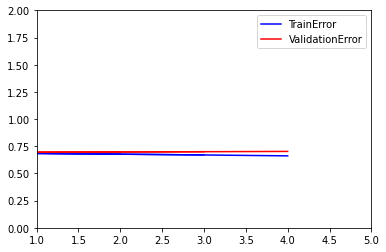

100%|██████████| 5/5 [00:18<00:00,  3.60s/it]


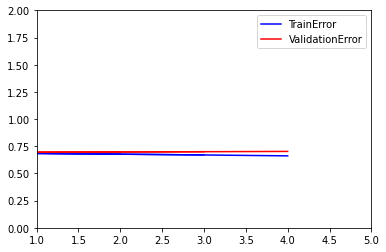

In [84]:
import torch.optim as optim
from train.model import LSTMClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(32, 100, 5000).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

report_train, trained_model = train(model, train_sample_dl, valid_sample_dl, 5, optimizer, loss_fn, device)

In [93]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="enhanced",
                    py_version="py3",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
 hyperparameters={
                        'epochs': 20,
                        'hidden_dim': 200,
     "vocab_size": new_vocab_size
                    })

In [94]:
estimator.fit({'training': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-12-08 02:19:02 Starting - Starting the training job...
2020-12-08 02:19:04 Starting - Launching requested ML instances......
2020-12-08 02:20:19 Starting - Preparing the instances for training......
2020-12-08 02:21:40 Downloading - Downloading input data...
2020-12-08 02:22:21 Training - Downloading the training image...
2020-12-08 02:22:46 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-12-08 02:22:47,167 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-12-08 02:22:47,192 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-12-08 02:22:47,412 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-12-08 02:22:50,730 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-12-08 02:22:50,731 sagemak

Model loaded with embedding_dim 32, hidden_dim 200, vocab_size 4998.
Epoch: 1; BCELoss: 0.6473525404930115;
Epoch: 2; BCELoss: 0.6462074597676595;
Epoch: 3; BCELoss: 0.6047688484191894;
Epoch: 4; BCELoss: 0.6201634128888448;
Epoch: 5; BCELoss: 0.4869344969590505;
Epoch: 6; BCELoss: 0.44531940420468646;
Epoch: 7; BCELoss: 0.5411289731661478;
Epoch: 8; BCELoss: 0.46696935494740804;
Epoch: 9; BCELoss: 0.40653617978096007;
Epoch: 10; BCELoss: 0.38722265760103863;
Epoch: 11; BCELoss: 0.37147785623868307;
Epoch: 12; BCELoss: 0.36188194155693054;
Epoch: 13; BCELoss: 0.3611917535463969;
Epoch: 14; BCELoss: 0.35835132797559105;
Epoch: 15; BCELoss: 0.3777260641256968;
Epoch: 16; BCELoss: 0.35818456411361693;
Epoch: 17; BCELoss: 0.4105056345462799;
Epoch: 18; BCELoss: 0.38733875354131064;
Epoch: 19; BCELoss: 0.37462220788002015;
Epoch: 20; BCELoss: 0.3902141769727071;
2020-12-08 02:28:05,429 sagemaker-containers INFO     Reporting training SUCCESS

2020-12-08 02:28:17 Uploading - Uploading genera

In [95]:
predictor = estimator.deploy(initial_instance_count=1,instance_type="ml.m4.xlarge")

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------------!

In [96]:
test_X_pred = pd.concat([pd.DataFrame(test_X_tf_len), pd.DataFrame(test_tf_X)], axis=1)

In [97]:
# We split the data into chunks and send each chunk seperately, accumulating the results.

def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in tqdm(split_array):
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

In [98]:
predictions = predict(test_X_pred.values)
predictions = [round(num) for num in predictions]

100%|██████████| 49/49 [05:28<00:00,  6.70s/it]


In [99]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(test_y, predictions)

0.85476

In [100]:
confusion_matrix(test_y, predictions)

array([[10665,  1835],
       [ 1796, 10704]])

In [40]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

In [44]:
xgb_hyperparameter_tuner = HyperparameterTuner(estimator = estimator, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:loss',
                                               metric_definitions = [{"Name": "validation:loss","Regex": "BCELoss: (.*?);"}],# The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 4, # The total number of models to train
                                               max_parallel_jobs = 1, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'epochs': IntegerParameter(10,11),
                                                    'hidden_dim': IntegerParameter(200,201),
                                                    #'embedding_dim': IntegerParameter(32,40)
                                               })

In [45]:
xgb_hyperparameter_tuner.fit({'training': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [52]:
xgb_hyperparameter_tuner.wait()

s


In [ ]:
best_model = xgb_hyperparameter_tuner.best_training_job()

In [ ]:
best_estimator = sagemaker.estimator.Estimator.attach(best_model)

In [ ]:
predictor = best_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

In [ ]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = PyTorchModel(model_data=best_estimator.model_data,
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     py_version="py3",
                     source_dir='serve',
                     predictor_cls=StringPredictor)

In [ ]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

In [ ]:
test_X = pd.concat([pd.DataFrame(test_X_len), pd.DataFrame(test_X)], axis=1)

In [ ]:
# We split the data into chunks and send each chunk seperately, accumulating the results.

def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in tqdm(split_array):
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

In [ ]:
import glob
import os
from tqdm import tqdm

def test_reviews(data_dir='data/aclImdb', stop=5000):
    
    results = []
    ground = []
    
    # We make sure to test both positive and negative reviews    
    for sentiment in ['pos', 'neg']:
        
        path = os.path.join(data_dir, 'test', sentiment, '*.txt')
        files = glob.glob(path)
        
        files_read = 0
        
        print('Starting ', sentiment, ' files')
        
        # Iterate through the files and send them to the predictor
        for f in tqdm(files):
            with open(f) as review:
                # First, we store the ground truth (was the review positive or negative)
                try:
                    # Read in the review and convert to 'utf-8' for transmission via HTTP
                    review_input = review.read().encode('utf-8')
                    # Send the review to the predictor and store the results
                    results.append(float(predictor.predict(review_input)))
                    if sentiment == 'pos':
                        ground.append(1)
                    else:
                        ground.append(0)
                except:
                    pass
                #print(results)
            # Sending reviews to our endpoint one at a time takes a while so we
            # only send a small number of reviews
            files_read += 1
            if files_read == stop:
                break
            
    return ground, results

In [ ]:
ground, results = test_reviews()

for idx in tqdm(range(n_test_sample)):
    pr_data_X = test_tf_X[idx]
    pr_data_len = test_X_tf_len[idx]
    pr_data_pack = np.hstack((pr_data_len, pr_data_X))
    pr_data_pack = pr_data_pack.reshape(1, -1)
    pr_data = torch.from_numpy(pr_data_pack)
    pr_data = pr_data.to(device)
    model.eval()
    result = model(pr_data).detach().numpy()
    predicted_values.append(result)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(ground, results)
fpr, tpr, _ = roc_curve(ground, results)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(ground, np.rint(results))

In [ ]:
confusion_matrix(ground, np.rint(results))